# ИСН – Анализ на големи данни за прецизната медицина – 2022 / 2023

# Проект Рак на простатата

# Есин Рашид, фак.номер 791322007

# Кристина Герчева, фак.номер 791322010

# Станислав Стоянов, фак.номер 791322012

<br><br>
### 1. Импортиране на необходимите библиотеки

In [1]:
import numpy as np # за линейната алгебра
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import math

# За визуализация на данните
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from IPython.display import Image, display
from plotly import graph_objs as go # Plotly for the interactive viewer
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

<br><br>
### 2. Прочитане на данните и създаване на клас Data, който ще се използва за съхранение на training и test datasets.

In [2]:
# Създаване на променливи, които съдържат пътя към dataset-а предоставени в заданието - https://www.kaggle.com/competitions/prostate-cancer-grade-assessment/data
train_data_path = "data/train.csv"
test_data_path = "data/test.csv"
sub_data_path = "data/sample_submission.csv"

In [3]:
# Създаване на клас Data, който ще съдържа тестовия и тренировъчния сет, както и функция consistency_check(), която ще
# проверява за консистентност на данните.

class Data:
    """ A util class to store the training and test datasets. """
    
    def __init__(self, tr_explanatory: pd.DataFrame, tr_explained: pd.DataFrame, 
                test_explanatory: pd.DataFrame, test_explained: pd.DataFrame):
        
        self.tr_explanatory = tr_explanatory
        self.tr_explained = tr_explained
        self.test_explanatory = test_explanatory
        self.test_explained = test_explained
    
    def consistency_check(self):
        print("Shape EXPLANATORY (Training set): {}".format(self.tr_explanatory.shape))
        print("Shape EXPLAINED (Training set): {}".format(self.tr_explained.shape))
        print("Shape EXPLANATORY (Test set): {}".format(self.test_explanatory.shape))
        print("Shape EXPLAINED (Test set): {}".format(self.test_explained.shape))
        
        if self.tr_explanatory.shape[0] == self.tr_explained.shape[0] and \
            self.test_explanatory.shape[0] == self.test_explained.shape[0] and \
            self.tr_explanatory.shape[1] == self.test_explanatory.shape[1] :
            print("Consistent dimensions.")
            return True
        else:
            print("ERROR: Inconsistent dimensions!")
            print(self.tr_explanatory.shape[0] == self.tr_explained.shape[0])
            print(self.test_explanatory.shape[0] == self.test_explained.shape[0])
            print(self.tr_explanatory.shape[1] == self.test_explanatory.shape[1])
            return False


### 3. Преглед на предоставените dataset-s

In [4]:
# Прочитане на данните от предоставените csv файлове
print('--Train Data--')
train_data = pd.read_csv(train_data_path)
train_data.info()
print(train_data.head()) # преглед на първите 5 реда

print('\n--Test Data--')
test_data = pd.read_csv(test_data_path)
test_data.info()
print(test_data.head()) # преглед на първите 5 реда

--Train Data--
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
dtypes: int64(1), object(3)
memory usage: 331.9+ KB
                           image_id data_provider  isup_grade gleason_score
0  0005f7aaab2800f6170c399693a96917    karolinska           0           0+0
1  000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0
2  0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4
3  001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4
4  001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0

--Test Data--
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 column

### Дефиниции на основните колони и етикетите от всеки институт

[train/test].csv
**image_id**: идентификационен номер на снимката.

**data_provider**: Името на институцията, предоставила данните. Както институтът Каролинска, така и Медицинският център на университета Radboud допринасят с данни. Те са използвали различни скенери с малко по-различни максимални микроскопски разделителни способности и са работили с различни патолози за етикетиране на изображенията.

**isup_grade**: Само за трениране, целева променлива. Тежест на рака по скала от 0-5.

**gleason_score**: Само за трениране. Алтернативна система за оценка на тежестта на рака с повече нива от скалата на ISUP.

**[train/test]_images**: Изображения. Всяка снимка представлява огромен tiff файл. Може да се очакват грубо 1000 снимки в скрития тестови сет. Обърнете внимание, че са въведени малко по-различни процедури за изображенията, използвани в тестовия набор от набора за обучение. Някои от изображенията от набора за обучение имат случайни следи от химикал, докато тези в тестовия сет са без такива следи.

**train_label_masks**: Маски за сегментиране, показващи кои части от изображението са довели до оценката на ISUP. Не всички тренировъчни изображения имат такива маски и може да има фалшиви положителни (false positives) или фалшиви негативи (false negatives) по различни причини. Тези маски са предоставени, за да помогнат при разработването на стратегии за избор на най-полезните подизвадки от изображенията. Стойностите на маската зависят от набора на данни:

**Radboud: Простатните жлези са индивидуално обозначени. Валидните стойности са**:

0: background (non tissue) or unknown

1: stroma (connective tissue, non-epithelium tissue)

2: healthy (benign) epithelium

3: cancerous epithelium (Gleason 3)

4: cancerous epithelium (Gleason 4)

5: cancerous epithelium (Gleason 5)

**Karolinska: Регионите са обозначени. Валидните стойности са**:

0: background (non tissue) or unknown

1: benign tissue (stroma and epithelium combined)

2: cancerous tissue (stroma and epithelium combined)

In [5]:
#Брой редове и колони в train data 
print('Number of rows and columns:{}'.format(train_data.shape))
print('Data providers: {}'.format(train_data["data_provider"].unique()))
print('ISUP Grade: {}'.format(len(train_data["isup_grade"].unique())))
print('Gleason Score: {}'.format(len(train_data["gleason_score"].unique())))
print('image ids : {}'.format(len(train_data["image_id"].unique())))

Number of rows and columns:(10616, 4)
Data providers: ['karolinska' 'radboud']
ISUP Grade: 6
Gleason Score: 11
image ids : 10616


In [6]:
#Брой редове и колони в test data
print('Number of rows and columns:{}'.format(test_data.shape))
print('Data providers: {}'.format(test_data["data_provider"].unique()))
print('image ids : {}'.format(len(test_data["image_id"].unique())))

Number of rows and columns:(3, 2)
Data providers: ['radboud' 'karolinska']
image ids : 3


In [7]:
#Преглед на липсващи данни
train_data.isna().sum() # брой на null стойностите във всяка колона

image_id         0
data_provider    0
isup_grade       0
gleason_score    0
dtype: int64

## 4. Обработка на данните
* създаване на training set, който се използва за "фитване" на класификаторите
* създаване на test set, който се използва за валидация на "фитнатите" класификатори
* визуализация на данните

In [8]:
#взимане на брой, средно, стандартно отклонение, минимум и максимум за всяка колона
train_data.describe()

isup_grade
count  10616.000000
mean       1.902223
std        1.719537
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max        5.000000

#### Каква роля играе оценката на GLEASON ?
Установяването на степента (агресивността) на раковите клетки е следващата стъпка, след като биопсията потвърди наличието на рак. Ракът се изследва в лаборатория от патолог, за да се открие колко ракови клетки се различават от нормалните клетки. Злокачествено заболяване с по-висок клас е по-вероятно да бъде агресивно и да се разпространи бързо. Gleason е най-популярната скала за определяне на степента на раковите клетки на простатата. Въпреки че долният край на диапазона не се използва толкова често, точкуването на Gleason включва два резултата и може да варира от 2 (неагресивно заболяване) до 10 (силно агресивен рак).

In [9]:
# Нека вземем 75% от данните
train_data = train_data.sample(frac=1).reset_index(drop=True) # random shuffle
number_of_rows = train_data.shape[0]  # брой редове
thr = math.floor(0.75*number_of_rows)  # използваме Threshold, за да разделим training от testing set

# Training subset
X = train_data.iloc[0:thr:, 1:-1]  # Explanatory variables
Y = train_data.iloc[0:thr:, -1]   # Target variable

# Testing subset
X_test = train_data.iloc[thr:number_of_rows:, 1:-1]  # Explanatory variables
Y_test = train_data.iloc[thr:number_of_rows:, -1]   # Target variable

# #############################
# Създаване на Data обекта 
train_data_object = Data(X, Y, X_test, Y_test)
# #############################

print("Threshold: " + str(thr))
train_data_object.consistency_check()  # извикваме consistency_check(), за да проверим за консистентност на данните

Threshold: 7962
Shape EXPLANATORY (Training set): (7962, 2)
Shape EXPLAINED (Training set): (7962,)
Shape EXPLANATORY (Test set): (2654, 2)
Shape EXPLAINED (Test set): (2654,)
Consistent dimensions.


True

## Train Dataset 

#### Функцията unique в pandas се използва за намиране на уникалните стойности от дадена серия. Поредицата е една колона от рамка от данни.


Тази част от кода преброява броя на извадките в рамката с данни train_data, които имат "gleason_score" от "0+0" или "отрицателен", и показва броя на извадките, които имат съответното "isup_grade".

Това може да бъде полезно за разбиране на разпределението на стойностите на "gleason_score" и "isup_grade" в набора от данни за обучение.

In [10]:
train_data['gleason_score'].unique()

array(['3+4', '4+3', '3+3', '4+5', 'negative', '0+0', '4+4', '5+4', '5+5',
       '3+5', '5+3'], dtype=object)

Ако оценката по Глийсън е изписана като 3+4=7, това означава, че по-голямата част от тумора е степен 3, а по-малката - степен 4, и те се сумират, за да се получи оценка по Глийсън 7. Други начини, по които тази оценка по Глийсън може да бъде изписана са: Глийсън 7/10, Глийсън 7 (3+4) или комбинирана оценка по Глийсън 7.

Ако всички тумори са от една и съща степен (например степен 3), тогава резултатът по Глийсън се отчита като 3+3=6.

In [11]:
print(len(train_data[train_data['gleason_score']=='0+0']['isup_grade']))
print(len(train_data[train_data['gleason_score']=='negative']['isup_grade']))

1925
967


In [12]:
# Това групира рамката с данни train_data по стойностите в колоната "isup_grade". 
# С други думи, тя създава отделни групи данни въз основа на всяка уникална стойност в колоната "isup_grade".

data = train_data.groupby('isup_grade').count()['image_id'].reset_index().sort_values(by='image_id',ascending=False)

#.count()['image_id']: Преброява се броят на случаите на поява на всяка стойност в колона "image_id" за всяка група, създадена в предишната стъпка. Тя връща DataFrame с две колони: 'isup_grade' и 'image_id'.
#.reset_index(): Тази функция нулира индекса на DataFrame до нов последователен индекс.
#.sort_values(by='image_id',ascending=False): Това подрежда DataFrame в низходящ ред въз основа на стойностите в колоната "image_id".

# Прилага градиентна цветова карта към DataFrame, като използва метода .style.background_gradient() на DataFrame. 
# Параметърът cmap указва цветовата карта, която да се използва, която в този случай е "viridis".
data.style.background_gradient(cmap= 'viridis')

#### Колкото по-висок е броят на "image_id", толкова повече са жълтият и зеленият цвят, които помагат за визуалното идентифициране на групите с по-висок брой на "image_id".

In [13]:
data = train_data.groupby('gleason_score').count()['image_id'].reset_index().sort_values(by='image_id',ascending=False)
data.style.background_gradient(cmap='Greens')

Оценки по Глийсън от 5 или по-малко обикновено не се използват. Диагноза с оценка на Глийсън 6 се счита за диагноза от ниска степен. Ракът от средна степен е с оценка на Глийсън 7, а ракът от висока степен - с оценка 8, 9 или 10. Ракът от нисък клас се развива по-постепенно и има по-малък шанс за раково развитие, отколкото ракът от висок клас.

In [14]:
# Създаване на фуниева диаграма
fig = go.Figure(go.Funnel(
    y = train_data['isup_grade'],
    x = train_data['image_id'],
    textposition = "inside",
    marker = {"color": data['image_id'],
              "color": ['Red','Green','Orange','cadetblue','Crimson', 'Purple']},
    textfont = {"color": "white"}
))

# Сетване на layout
fig.update_layout(
    title = "ISUP_grade Distribution Funnel Chart",
    yaxis_title = "ISUP_grade",
    xaxis_title = "Number of Images",
    font_family = "Arial",
)

fig.show()

Създаване на фуниева диаграма с помощта на библиотеката plotly за визуализиране на разпределението на колоната "isup_grade" в рамката с данни "train_data". Диаграмата показва колко изображения принадлежат към всяка категория 'isup_grade'. Цветовете на сегментите на диаграмата се задават въз основа на броя на идентификаторите на изображенията за всяка категория. Аргументите y и x се задават съответно на колоните "isup_grade" и "image_id" на данните. Аргументът за маркера се задава към колоната "image_id" на данните, която задава цвета на всеки сегмент на фуниевидната диаграма въз основа на броя на изображенията за всеки "isup_grade". Аргументите textposition и textfont се използват за показване на етикетите в диаграмата на фунията.

Получената диаграма е озаглавена "ISUP_grade Distribution Funnel Chart" (Диаграма на фунията на разпределението на ISUP_grade), а осите x и y са съответно обозначени. Диаграмата се показва с помощта на метода show().

In [15]:
fig = go.Figure(data=[go.Bar(
    x=train_data['isup_grade'], y=train_data['image_id'],
    hoverinfo='y',
    marker=dict(color=['Red','Green','Orange','Purple','Blue','Yellow'])
)])

# Set the layout
fig.update_layout(
    title='ISUP_grade and image_id Bar Chart',
    xaxis_title='ISUP_grade',
    yaxis_title='Number of Images'
)

# Show the chart
fig.show()

Системата за класификация ISUP е по-нов и по-прост метод за класификация на рака на простатата в сравнение с използваната преди това система, базирана на скалата на Глийсън. Тя използва петстепенна скала за класифициране на рака на простатата въз основа на моделите на развитие на клетките, видими под микроскоп, като варира от степен 1 (най-малко агресивна) до степен 5 (най-агресивна). Извадката от код създава стълбовидна диаграма, използвайки библиотеката plotly, за да визуализира разпределението на колоните "isup_grade" и "image_id" в dataFrame train_data. По оста x са представени категориите ISUP_grade, а по оста y - броят на изображенията. Всеки стълб в графиката е оцветен по различен начин в зависимост от категорията, която представлява. Диаграмата е озаглавена "ISUP_grade and image_id Bar Chart", а осите x и y са обозначени по съответния начин. Получената диаграма се показва с помощта на метода show().

In [16]:
train_data.head()

image_id data_provider  isup_grade gleason_score
0  ea2f3faabd452477e8f792ca02925cd0       radboud           2           3+4
1  d52bc4ddd5d4efb8a99e68bc9d597fa6       radboud           3           4+3
2  591be7bd1ced8a42f257d9a467cb7133       radboud           1           3+3
3  57ac237fd7804341517927ced4353c71       radboud           5           4+5
4  170c91c206648c545cfe69c718c059f2       radboud           0      negative

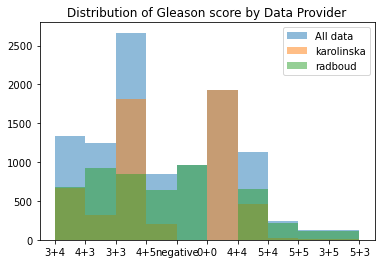

In [17]:
# Създаване на хистограма за Gleason score
plt.hist(train_data['gleason_score'], bins=10, alpha=0.5, label='All data')
plt.hist(train_data[train_data['data_provider'] == 'karolinska']['gleason_score'], bins=10, alpha=0.5, label='karolinska')
plt.hist(train_data[train_data['data_provider'] == 'radboud']['gleason_score'], bins=10, alpha=0.5, label='radboud')
# plt.hist(data[data['Data provider'] == 'Provider C']['Gleason score'], bins=10, alpha=0.5, label='Provider C')

# Добавяне на легенда и заглавие
plt.legend(loc='upper right')
plt.title('Distribution of Gleason score by Data Provider')

# Визуализиране на хистограмата
plt.show()

Групиране на данните по isup_grade и data_provider и преброяване на броя на появяванията с помощта на метода size(), след което завъртане на данните, за да се създаде матрица, подходяща за изчертаване на графики, с isup_grade като индекс и data_provider като колона. Накрая, данните се визуализират като стълбовидна диаграма, чрез използване на plot(kind='bar', stacked=False). Добавя се заглавие и етикети на осите с помощта на title(), xlabel() и ylabel().

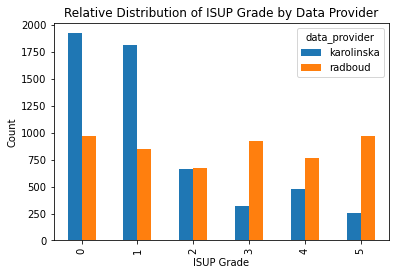

In [18]:
# Групиране на данните по isup_grade и data_provider
grouped_data = train_data.groupby(['isup_grade', 'data_provider']).size().reset_index(name='count')

# Създаване на матрица за изчертаване на данните
pivot_data = grouped_data.pivot(index='isup_grade', columns='data_provider', values='count')

# Визуализация под формата на стълбовидна диаграма
pivot_data.plot(kind='bar', stacked=False)

# Добавяне на заглавие и етикети
plt.title('Relative Distribution of ISUP Grade by Data Provider')
plt.xlabel('ISUP Grade')
plt.ylabel('Count')

# Визуализация на диаграмата
plt.show()

По-голямата част от данните за категории 0 и 1 на класа isup са предоставени от karolinska. По-голямата част от данните за категориите 3, 4 и 5 на isup се предоставят от radboud.

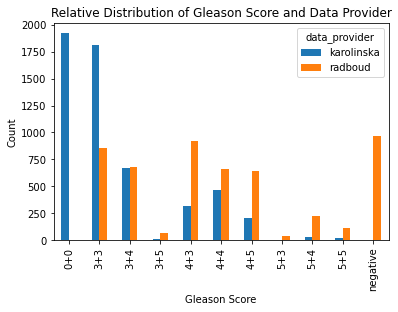

In [19]:
# Групиране на данните по isup_grade и data_provider и преброяване по image_id
grouped_data = train_data.groupby(['gleason_score', 'data_provider'])['image_id'].count().reset_index()

# Създаване на матрица за изчертаване на данните
pivoted_data = grouped_data.pivot(index='gleason_score', columns='data_provider', values='image_id')

# Визуализация под формата на стълбовидна диаграма
pivoted_data.plot(kind='bar', stacked=False)

# Добавяне на заглавие и етикети
plt.xlabel('Gleason Score')
plt.ylabel('Count')
plt.title('Relative Distribution of Gleason Score and Data Provider')

# Визуализация на диаграмата
plt.show()

Всяка информация за категорията на резултата на Глейсън (0+0) идва от karolinska.

Цялата информация за категорията "отрицателен резултат" е предоставена от radboud.

Karolinska е значителен източник на данни за категорията "оценка по Gleason" (3+3).

Radbound обаче е значителен източник на данни за категориите (4+4), (4+3), (4+5), (5+4), (5+5), (5+3) и (3+5).

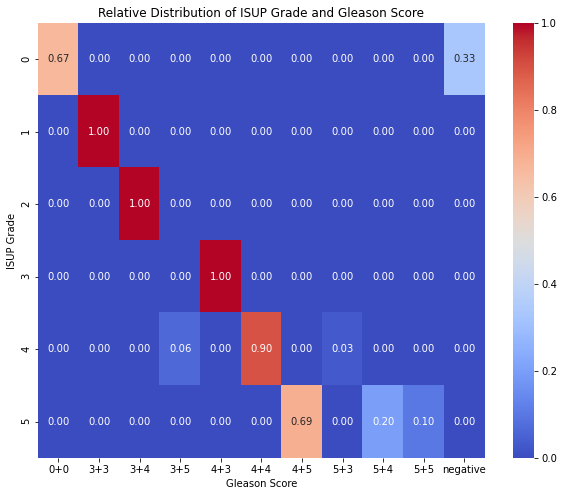

In [20]:
# функцията crosstab() се използва за създаване на кръстосана таблица на 
# isup_grade спрямо gleason_score, като параметърът normalize е зададен на 
# 'index', за да се нормализират числата по редове. Получената кръстосана таблица 
# след това се изобразява с помощта на функцията heatmap() от библиотеката seaborn.

# Получената топлинна карта ще покаже относителното разпределение на 
# isup_grade и gleason_score, като всяка клетка представлява пропорцията 
# на изображенията в съответната група isup_grade и gleason_score. 
# Цветът на всяка клетка показва съотношението, като по-тъмните цветове 
# показва по-високи дялове. Анотациите във всяка клетка показват 
# пропорциите като проценти. Тази графика може да бъде полезна за идентифициране на всякакви 
# модели или тенденции в разпределението на данните.

# Създаване на cross-tabulation isup_grade vs gleason_score
cross_tab = pd.crosstab(train_data['isup_grade'], train_data['gleason_score'], normalize='index')

# Създаване на фигура с размерност 10-inch ширина и 8-inch височина
plt.figure(figsize=(10, 8))

# Създаване на heatmap
sns.heatmap(cross_tab, cmap='coolwarm', annot=True, fmt='.2f')

# Добавяне на заглавие и етикети
plt.xlabel('Gleason Score')
plt.ylabel('ISUP Grade')
plt.title('Relative Distribution of ISUP Grade and Gleason Score')

# Визуализация на диаграмата
plt.show()

### 5. Анализ на проучвателни данни за изображения (EDA)

#### Какво представлява форматът .tff и защо се използва?

Маркираният файлов формат за изображения (TIFF) е битов формат за изображения с променлива разделителна способност, разработен от Aldus (сега част от Adobe) през 1986 г. TIFF е много разпространен за пренасяне на цветни или сиви изображения в приложения за оформление на страници, но е по-малко подходящ за предоставяне на уеб съдържание.

#### Какво представлява дискретизацията надолу и дискретизацията нагоре при обработката на изображения?

Методите за обработка на цифрови изображения, като намаляване и увеличаване на дискретизацията, се използват за промяна на разделителната способност на изображението.

https://www.geeksforgeeks.org/spatial-resolution-down-sampling-and-up-sampling-in-image-processing/

openslide за показване на изображения: https://www.kaggle.com/wouterbulten/getting-started-with-the-panda-dataset
Предимството на OpenSlide е, че можем да зареждаме произволни области от слайда, без да зареждаме цялото изображение в паметта.

Документация за OpenSlide на python: https://openslide.org/api/python/

In [21]:
# locating the images 

folder_path = '/kaggle/input/prostate-cancer-grade-assessment'

# image and mask directories

data_dir = f'{folder_path}/train_images'
mask_dir = f'{folder_path}/train_label_masks'

#### Разбиране на маските
##### Какво представляват маските?
Освен етикета на ниво слайд (присъстващ във файла csv), почти всички слайдове в учебния набор имат свързана маска с допълнителна информация за етикета. Тези маски директно посочват кои части от тъканта са здрави и кои са ракови.тези маски се предоставят, за да подпомогнат разработването на стратегии за избор на най-полезните подпроби от изображенията. Стойностите на маските зависят от доставчика на данни:

###### Radboud: Простатните жлези са индивидуално маркирани, Допустимите стойности са:

     0: фон (без тъкан) или неизвестен
     1: строма (съединителна тъкан, тъкан, различна от епитела)
     2: здрав (доброкачествен) епител
     3: раков епител (Gleason 3)
     4: раков епител (Gleason 4)
     5: раков епител (Gleason 5)
     
###### karolinska: Регионите са маркирани, валидните стойности са:

      1: фон (без тъкан) или неизвестен
      2: доброкачествена тъкан (строма и епител заедно)
      3: ракова тъкан (строма и епител заедно)

### 6. Преглед на втори dataset без изображения

Този dataset съдържа таблични данни за изследвания на 100 пациента и има 10 променливи (9 от които числови променливи и 1 категорийна - Id).
1. Id - Уникален идентификационен номер за всяка проба в дейтасета.
2. Radius - Средното разстояние между центъра и периметъра на тумора.
3. Texture - Стандартното отклонение на стойностите на сивата скала в изображението на тумора.
4. Perimeter - Периметърът или дължината на тумора.
5. Area - Площта или общия брой пиксели на тумора.
6. Smoothness - Вариация в дължината на радиуса.
7. Compactness - Мярка за компактност на тумора, изчислена като (периметър^2) / (4 * pi * площта).
8. diagnosis_result - Резултатът от диагнозата за всяка проба. Индикира дали пробата има етикет злокачествен (M) или доброкачествен (B). Злокачествените се отнасят за ракови клетки, а доброкачествените за неракови.
9. Symmetry -  Мярка за симетрия представляваща приликата между двете половини на тумора.
10. Fractal dimension - Мярка за сложността на тумора.

In [22]:
# Създаване на променлива path, която ще съдържа пътя към dataset-а предоставен в заданието
prostate_path = "data/Prostate_Cancer.csv"

In [23]:
# Прочитане и преглед на dataset от предоставения csv файл
prostate_cancer = pd.read_csv(prostate_path)
prostate_cancer.info()
prostate_cancer.head(10)
print(prostate_cancer.tail())
print(prostate_cancer.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 100 non-null    int64  
 1   diagnosis_result   100 non-null    object 
 2   radius             100 non-null    int64  
 3   texture            100 non-null    int64  
 4   perimeter          100 non-null    int64  
 5   area               100 non-null    int64  
 6   smoothness         100 non-null    float64
 7   compactness        100 non-null    float64
 8   symmetry           100 non-null    float64
 9   fractal_dimension  100 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 7.9+ KB
     id diagnosis_result  radius  texture  perimeter  area  smoothness  \
95   96                M      23       16        132  1264       0.091   
96   97                B      22       14         78   451       0.105   
97   98                B      19    

### 7. Обработка на данните

In [24]:
# Принтиране на съществуващите колони в набора от данни
print(prostate_cancer.columns)

Index(['id', 'diagnosis_result', 'radius', 'texture', 'perimeter', 'area',
       'smoothness', 'compactness', 'symmetry', 'fractal_dimension'],
      dtype='object')


In [25]:
# Премахване колоната за id, от която не се нуждаем
prostate_cancer.drop(['id'],axis=1,inplace=True)

In [26]:
prostate_cancer.head()

diagnosis_result  radius  texture  perimeter  area  smoothness  compactness  \
0                M      23       12        151   954       0.143        0.278   
1                B       9       13        133  1326       0.143        0.079   
2                M      21       27        130  1203       0.125        0.160   
3                M      14       16         78   386       0.070        0.284   
4                M       9       19        135  1297       0.141        0.133   

   symmetry  fractal_dimension  
0     0.242              0.079  
1     0.181              0.057  
2     0.207              0.060  
3     0.260              0.097  
4     0.181              0.059

In [27]:
# diagnosis_result е най-важната колона за нас, защото ще класифицираме по нея
# Следователно, ще обърнем стойността и от текстов вид в числов. Там където стойността е M (злокачествен) ще преобразуваме в 1,
# в противен случай 0.
prostate_cancer.diagnosis_result = [1 if each == 'M' else 0 for each in prostate_cancer.diagnosis_result]

In [28]:
# Създаване на корелационна матрица (heatmap)
corr_metrics = prostate_cancer.corr()
corr_metrics.style.background_gradient()

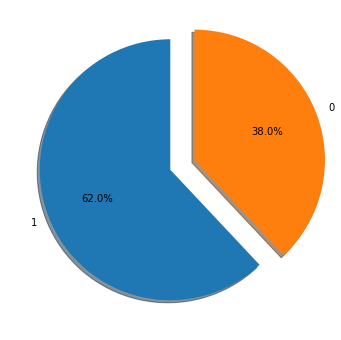

In [29]:
# По-голямата част от случаите се оказват злокачествени
diagnosis_result_dr = prostate_cancer.diagnosis_result.value_counts()

label = [diagnosis_result_dr.index.tolist()]
plt.pie(diagnosis_result_dr, labels=label[0], shadow=True, explode=(0.0, 0.2), autopct='%1.1f%%', startangle=90)
plt.gcf().set_size_inches(12,6)
plt.show()

In [30]:
# Инициализираме x и y променливите, които ще ползваме за нашето test-train datasets разделяне
y = prostate_cancer.diagnosis_result.values
x_data = prostate_cancer.drop(['diagnosis_result'],axis=1)

In [31]:
x_data.head()

radius  texture  perimeter  area  smoothness  compactness  symmetry  \
0      23       12        151   954       0.143        0.278     0.242   
1       9       13        133  1326       0.143        0.079     0.181   
2      21       27        130  1203       0.125        0.160     0.207   
3      14       16         78   386       0.070        0.284     0.260   
4       9       19        135  1297       0.141        0.133     0.181   

   fractal_dimension  
0              0.079  
1              0.057  
2              0.060  
3              0.097  
4              0.059

In [32]:
# Нормализираме стойностите като използваме MinMaxScaler (привеждаме ме ги във вид между 0 и 1)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
x = scaler.fit_transform(x_data)
print(x)

[[0.875      0.0625     0.825      0.44868735 1.         0.78175896
  0.63313609 0.59090909]
 [0.         0.125      0.675      0.67064439 1.         0.13355049
  0.27218935 0.09090909]
 [0.75       1.         0.65       0.59725537 0.75342466 0.39739414
  0.4260355  0.15909091]
 [0.3125     0.3125     0.21666667 0.1097852  0.         0.80130293
  0.73964497 1.        ]
 [0.         0.5        0.69166667 0.65334129 0.97260274 0.30944625
  0.27218935 0.13636364]
 [1.         0.875      0.25833333 0.16408115 0.79452055 0.42996743
  0.43786982 0.52272727]
 [0.4375     0.9375     0.56666667 0.5        0.34246575 0.23127036
  0.26035503 0.09090909]
 [0.375      0.4375     0.31666667 0.22434368 0.67123288 0.41368078
  0.50295858 0.5       ]
 [0.625      0.8125     0.3        0.18973747 0.78082192 0.50488599
  0.59171598 0.47727273]
 [1.         0.         0.26666667 0.16348449 0.67123288 0.65798046
  0.40236686 0.65909091]
 [0.9375     0.625      0.425      0.35560859 0.16438356 0.09446254
  

In [33]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)
method_names=[]
method_scores=[]
x_train

array([[0.5625    , 0.125     , 0.175     , 0.12350835, 0.34246575,
        0.05537459, 0.33727811, 0.13636364],
       [0.125     , 0.        , 0.23333333, 0.1575179 , 0.24657534,
        0.18241042, 0.34319527, 0.25      ],
       [0.0625    , 0.8125    , 0.375     , 0.26431981, 0.47945205,
        0.48534202, 0.53254438, 0.36363636],
       [0.125     , 0.        , 0.63333333, 0.53818616, 0.28767123,
        0.58957655, 0.56804734, 0.22727273],
       [0.5       , 0.625     , 0.24166667, 0.17959427, 0.38356164,
        0.04560261, 0.14201183, 0.09090909],
       [0.8125    , 0.5       , 0.375     , 0.27267303, 0.60273973,
        0.39739414, 0.56213018, 0.40909091],
       [0.9375    , 0.3125    , 0.28333333, 0.21539379, 0.16438356,
        0.07166124, 0.25443787, 0.06818182],
       [0.8125    , 0.1875    , 0.21666667, 0.14856802, 0.47945205,
        0.10749186, 0.32544379, 0.29545455],
       [1.        , 0.        , 0.26666667, 0.16348449, 0.67123288,
        0.65798046, 0.402366

### 8. Прилагане на класификационни алгоритми

Logistic Regression Classification Test Accuracy: 0.8

              precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       0.83      0.94      0.88        16

    accuracy                           0.80        20
   macro avg       0.67      0.59      0.61        20
weighted avg       0.77      0.80      0.77        20



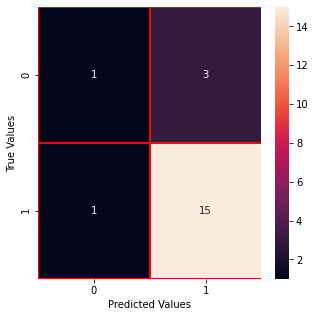

In [34]:
# Логистична регресия
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
print("Logistic Regression Classification Test Accuracy: {}\n".format(log_reg.score(x_test,y_test)))
method_names.append("Logistic Reg.")
method_scores.append(log_reg.score(x_test,y_test))
pred_log = log_reg.predict(x_test)
class_rep_log = classification_report(y_test, pred_log)
print(class_rep_log)

# Confusion Matrix
y_pred = log_reg.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)

# Визуализация на матрицата
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

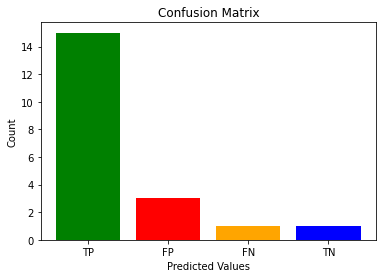

In [35]:
# Confusion Matrix
y_pred = log_reg.predict(x_test)
conf_mat = confusion_matrix(y_test, y_pred)

# Извличане на TP, FP, FN, TN
TP = conf_mat[1, 1]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TN = conf_mat[0, 0]

# Създаване на подредена стълбовидна диаграма
labels = ['TP', 'FP', 'FN', 'TN']
values = [TP, FP, FN, TN]
colors = ['green', 'red', 'orange', 'blue']

plt.bar(labels, values, color=colors)

# Добавяне на етикети и заглавие
plt.xlabel('Predicted Values')
plt.ylabel('Count')
plt.title('Confusion Matrix')

# Визуализиране на графиката
plt.show()

Score for Number of Neighbors = 5: 0.8

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.80      1.00      0.89        16

    accuracy                           0.80        20
   macro avg       0.40      0.50      0.44        20
weighted avg       0.64      0.80      0.71        20



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



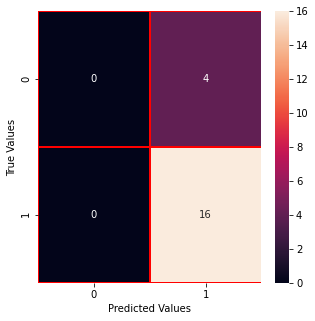

In [36]:
# K-Neighbors (метод на съседите)
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train,y_train)
print("Score for Number of Neighbors = 5: {}\n".format(knn.score(x_test,y_test)))
method_names.append("KNN")
method_scores.append(knn.score(x_test,y_test))
pred_knn = knn.predict(x_test)
class_rep_knn = classification_report(y_test, pred_knn)
print(class_rep_knn)

# Confusion Matrix
y_pred = knn.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)

# Визуализация
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

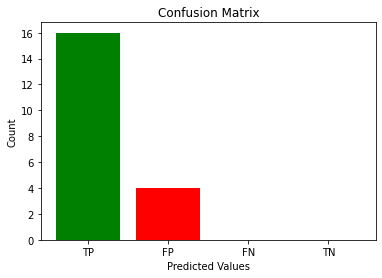

In [37]:
# Confusion Matrix
y_pred = knn.predict(x_test)
conf_mat = confusion_matrix(y_test, y_pred)

# Извличане на TP, FP, FN, TN
TP = conf_mat[1, 1]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TN = conf_mat[0, 0]

# Създаване на подредена стълбовидна диаграма
labels = ['TP', 'FP', 'FN', 'TN']
values = [TP, FP, FN, TN]
colors = ['green', 'red', 'orange', 'blue']

plt.bar(labels, values, color=colors)

# Добавяне на етикети и заглавие
plt.xlabel('Predicted Values')
plt.ylabel('Count')
plt.title('Confusion Matrix')

# Визуализиране на графиката
plt.show()

Naive Bayes Test Accuracy: 0.8

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.88      0.88      0.88        16

    accuracy                           0.80        20
   macro avg       0.69      0.69      0.69        20
weighted avg       0.80      0.80      0.80        20



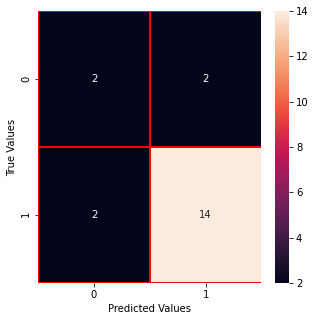

In [38]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes.fit(x_test,y_test)
print("Naive Bayes Test Accuracy: {}\n".format(naive_bayes.score(x_test,y_test)))
method_names.append("Naive Bayes")
method_scores.append(naive_bayes.score(x_test,y_test))
pred_naive_bayes = naive_bayes.predict(x_test)
class_rep_naive_bayes = classification_report(y_test, pred_naive_bayes)
print(class_rep_naive_bayes)

# Confusion Matrix
y_pred = naive_bayes.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)

# Визуализация на матрицата
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

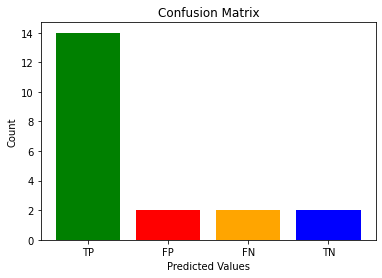

In [39]:
# Confusion Matrix
y_pred = naive_bayes.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)

# Извличане на TP, FP, FN, TN
TP = conf_mat[1, 1]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TN = conf_mat[0, 0]

# Създаване на подредена стълбовидна диаграма
labels = ['TP', 'FP', 'FN', 'TN']
values = [TP, FP, FN, TN]
colors = ['green', 'red', 'orange', 'blue']

plt.bar(labels, values, color=colors)

# Добавяне на етикети и заглавие
plt.xlabel('Predicted Values')
plt.ylabel('Count')
plt.title('Confusion Matrix')

# Визуализиране на графиката
plt.show()

Decision Tree Test Accuracy:  0.65

              precision    recall  f1-score   support

           0       0.20      0.25      0.22         4
           1       0.80      0.75      0.77        16

    accuracy                           0.65        20
   macro avg       0.50      0.50      0.50        20
weighted avg       0.68      0.65      0.66        20



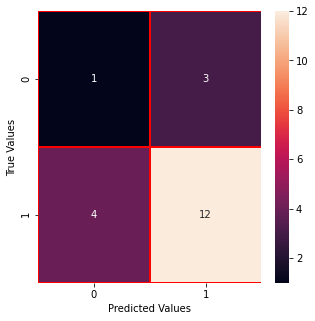

In [40]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier()
dec_tree.fit(x_train,y_train)
print("Decision Tree Test Accuracy: ",dec_tree.score(x_test,y_test))
method_names.append("Decision Tree")
method_scores.append(dec_tree.score(x_test,y_test))
pred_dec_tree = dec_tree.predict(x_test)
class_rep_dec_tree = classification_report(y_test, pred_dec_tree)
print("\n" + class_rep_dec_tree)

# Confusion Matrix
y_pred = dec_tree.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)

# Визуализация на матрицата
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

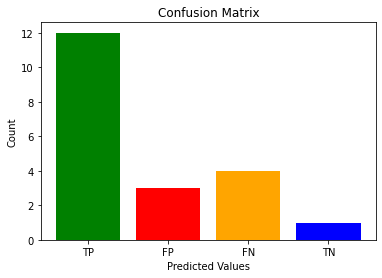

In [41]:
# Confusion Matrix
y_pred = dec_tree.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)

# Извличане на TP, FP, FN, TN
TP = conf_mat[1, 1]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TN = conf_mat[0, 0]

# Създаване на подредена стълбовидна диаграма
labels = ['TP', 'FP', 'FN', 'TN']
values = [TP, FP, FN, TN]
colors = ['green', 'red', 'orange', 'blue']

plt.bar(labels, values, color=colors)

# Добавяне на етикети и заглавие
plt.xlabel('Predicted Values')
plt.ylabel('Count')
plt.title('Confusion Matrix')

# Визуализиране на графиката
plt.show()

Random Forest Test Accuracy:  0.75

              precision    recall  f1-score   support

           0       0.20      0.25      0.22         4
           1       0.80      0.75      0.77        16

    accuracy                           0.65        20
   macro avg       0.50      0.50      0.50        20
weighted avg       0.68      0.65      0.66        20



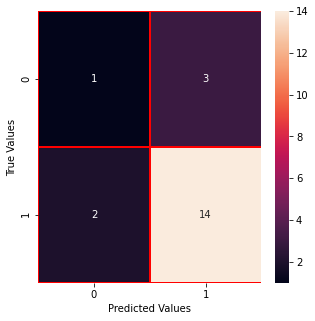

In [42]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rand_forest = RandomForestClassifier(n_estimators=100, random_state=42)
rand_forest.fit(x_train,y_train)
print("Random Forest Test Accuracy: ",rand_forest.score(x_test,y_test))
method_names.append("Random Forest")
method_scores.append(rand_forest.score(x_test,y_test))
pred_rand_forest = rand_forest.predict(x_test)
class_rep_rand_forest = classification_report(y_test, pred_rand_forest)
print("\n" + class_rep_dec_tree)

# Confusion Matrix
y_pred = rand_forest.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)

# Визуализация на матрицата
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

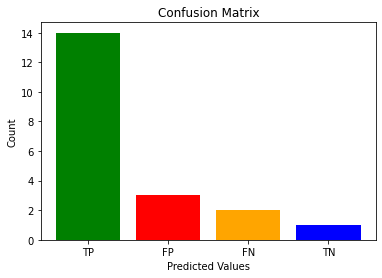

In [43]:
# Confusion Matrix
y_pred = rand_forest.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)

# Извличане на TP, FP, FN, TN
TP = conf_mat[1, 1]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TN = conf_mat[0, 0]

# Създаване на подредена стълбовидна диаграма
labels = ['TP', 'FP', 'FN', 'TN']
values = [TP, FP, FN, TN]
colors = ['green', 'red', 'orange', 'blue']

plt.bar(labels, values, color=colors)

# Добавяне на етикети и заглавие
plt.xlabel('Predicted Values')
plt.ylabel('Count')
plt.title('Confusion Matrix')

# Визуализиране на графиката
plt.show()

### 9. Deep Learning

#### ANN

In [44]:
# ANN!

# Импортиране на необходимите библиотеки

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential # initialize neural network library
from keras.layers import Dense # build our layers library

# Функция за изграждане на класификатора
def build_classifier():
    classifier = Sequential() # Иницииране на невронна мрежа
    # Добавяне на входен слой с 50 единици/неврони, като се използва функцията за активиране 'relu'
    classifier.add(Dense(units = 50, kernel_initializer = 'uniform', activation = 'relu', input_dim = x_train.shape[1])) 
    # Добавяне на скрит слой с 10 единици/неврони, като се използва функцията за активиране "relu
    classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))
    # Добавяне на изходен слой с 1 единица/неврон, като се използва функцията за активиране "sigmoid"
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    # Компилирайте класификатора, като използвате оптимизатора 'adam' и функцията за загуба 'binary_crossentropy'
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

# Създаване на обект KerasClassifier с помощта на функцията build_classifier, с 200 епохи
classifier = KerasClassifier(build_fn = build_classifier, epochs = 200)
# Извършване на кръстосано валидиране на класификатора
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 3)

# Изчислете средната стойност и дисперсията на точността
mean = accuracies.mean()
variance = accuracies.std()

# Отпечатване на резултатите
print("Accuracy mean: "+ str(mean))
print("Accuracy variance: "+ str(variance))

<ipython-input-44-20d742abdeb9>:24: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



Epoch 1/200
2/2 [==============================] - 2s 15ms/step - loss: 0.6932 - accuracy: 0.4151
Epoch 2/200
2/2 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.6415
Epoch 3/200
2/2 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.5472
Epoch 4/200
2/2 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5472
Epoch 5/200
2/2 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5472
Epoch 6/200
2/2 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5472
Epoch 7/200
2/2 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.5472
Epoch 8/200
2/2 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5472
Epoch 9/200
2/2 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.5472
Epoch 10/200
2/2 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.5472
Epoch 11/200
2/2 [==========

2/2 [==============================] - 0s 7ms/step - loss: 0.4642 - accuracy: 0.8868
Epoch 85/200
2/2 [==============================] - 0s 8ms/step - loss: 0.4608 - accuracy: 0.8868
Epoch 86/200
2/2 [==============================] - 0s 7ms/step - loss: 0.4576 - accuracy: 0.8868
Epoch 87/200
2/2 [==============================] - 0s 7ms/step - loss: 0.4545 - accuracy: 0.8868
Epoch 88/200
2/2 [==============================] - 0s 9ms/step - loss: 0.4513 - accuracy: 0.8868
Epoch 89/200
2/2 [==============================] - 0s 6ms/step - loss: 0.4489 - accuracy: 0.8868
Epoch 90/200
2/2 [==============================] - 0s 8ms/step - loss: 0.4460 - accuracy: 0.8868
Epoch 91/200
2/2 [==============================] - 0s 7ms/step - loss: 0.4424 - accuracy: 0.8868
Epoch 92/200
2/2 [==============================] - 0s 7ms/step - loss: 0.4392 - accuracy: 0.8868
Epoch 93/200
2/2 [==============================] - 0s 7ms/step - loss: 0.4363 - accuracy: 0.8679
Epoch 94/200
2/2 [===============

2/2 [==============================] - 0s 16ms/step - loss: 0.2818 - accuracy: 0.9245
Epoch 167/200
2/2 [==============================] - 0s 15ms/step - loss: 0.2794 - accuracy: 0.9245
Epoch 168/200
2/2 [==============================] - 0s 16ms/step - loss: 0.2782 - accuracy: 0.9245
Epoch 169/200
2/2 [==============================] - 0s 13ms/step - loss: 0.2774 - accuracy: 0.9434
Epoch 170/200
2/2 [==============================] - 0s 16ms/step - loss: 0.2766 - accuracy: 0.9434
Epoch 171/200
2/2 [==============================] - 0s 16ms/step - loss: 0.2755 - accuracy: 0.9434
Epoch 172/200
2/2 [==============================] - 0s 13ms/step - loss: 0.2742 - accuracy: 0.9434
Epoch 173/200
2/2 [==============================] - 0s 11ms/step - loss: 0.2729 - accuracy: 0.9434
Epoch 174/200
2/2 [==============================] - 0s 11ms/step - loss: 0.2712 - accuracy: 0.9434
Epoch 175/200
2/2 [==============================] - 0s 11ms/step - loss: 0.2703 - accuracy: 0.9245
Epoch 176/200


2/2 [==============================] - 0s 8ms/step - loss: 0.6327 - accuracy: 0.5660
Epoch 49/200
2/2 [==============================] - 0s 9ms/step - loss: 0.6289 - accuracy: 0.5660
Epoch 50/200
2/2 [==============================] - 0s 9ms/step - loss: 0.6251 - accuracy: 0.5849
Epoch 51/200
2/2 [==============================] - 0s 8ms/step - loss: 0.6214 - accuracy: 0.5849
Epoch 52/200
2/2 [==============================] - 0s 7ms/step - loss: 0.6170 - accuracy: 0.6038
Epoch 53/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6126 - accuracy: 0.6226
Epoch 54/200
2/2 [==============================] - 0s 8ms/step - loss: 0.6085 - accuracy: 0.6415
Epoch 55/200
2/2 [==============================] - 0s 9ms/step - loss: 0.6044 - accuracy: 0.6415
Epoch 56/200
2/2 [==============================] - 0s 8ms/step - loss: 0.5996 - accuracy: 0.6415
Epoch 57/200
2/2 [==============================] - 0s 9ms/step - loss: 0.5949 - accuracy: 0.6415
Epoch 58/200
2/2 [==============

2/2 [==============================] - 0s 8ms/step - loss: 0.3506 - accuracy: 0.9057
Epoch 132/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3486 - accuracy: 0.9057
Epoch 133/200
2/2 [==============================] - 0s 9ms/step - loss: 0.3464 - accuracy: 0.9057
Epoch 134/200
2/2 [==============================] - 0s 11ms/step - loss: 0.3442 - accuracy: 0.9057
Epoch 135/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3421 - accuracy: 0.9057
Epoch 136/200
2/2 [==============================] - 0s 9ms/step - loss: 0.3401 - accuracy: 0.9057
Epoch 137/200
2/2 [==============================] - 0s 9ms/step - loss: 0.3377 - accuracy: 0.9057
Epoch 138/200
2/2 [==============================] - 0s 9ms/step - loss: 0.3363 - accuracy: 0.8868
Epoch 139/200
2/2 [==============================] - 0s 7ms/step - loss: 0.3338 - accuracy: 0.8868
Epoch 140/200
2/2 [==============================] - 0s 9ms/step - loss: 0.3318 - accuracy: 0.9057
Epoch 141/200
2/2 [====

2/2 [==============================] - 0s 9ms/step - loss: 0.6872 - accuracy: 0.6296
Epoch 14/200
2/2 [==============================] - 0s 8ms/step - loss: 0.6864 - accuracy: 0.6296
Epoch 15/200
2/2 [==============================] - 0s 9ms/step - loss: 0.6857 - accuracy: 0.6296
Epoch 16/200
2/2 [==============================] - 0s 8ms/step - loss: 0.6845 - accuracy: 0.6296
Epoch 17/200
2/2 [==============================] - 0s 11ms/step - loss: 0.6837 - accuracy: 0.6296
Epoch 18/200
2/2 [==============================] - 0s 9ms/step - loss: 0.6823 - accuracy: 0.6296
Epoch 19/200
2/2 [==============================] - 0s 12ms/step - loss: 0.6811 - accuracy: 0.6296
Epoch 20/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6796 - accuracy: 0.6296
Epoch 21/200
2/2 [==============================] - 0s 12ms/step - loss: 0.6781 - accuracy: 0.6296
Epoch 22/200
2/2 [==============================] - 0s 13ms/step - loss: 0.6763 - accuracy: 0.6296
Epoch 23/200
2/2 [==========

2/2 [==============================] - 0s 8ms/step - loss: 0.3706 - accuracy: 0.8889
Epoch 97/200
2/2 [==============================] - 0s 7ms/step - loss: 0.3685 - accuracy: 0.8889
Epoch 98/200
2/2 [==============================] - 0s 9ms/step - loss: 0.3666 - accuracy: 0.8889
Epoch 99/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3652 - accuracy: 0.8889
Epoch 100/200
2/2 [==============================] - 0s 9ms/step - loss: 0.3623 - accuracy: 0.8889
Epoch 101/200
2/2 [==============================] - 0s 9ms/step - loss: 0.3608 - accuracy: 0.8889
Epoch 102/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3595 - accuracy: 0.8889
Epoch 103/200
2/2 [==============================] - 0s 7ms/step - loss: 0.3584 - accuracy: 0.8704
Epoch 104/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3555 - accuracy: 0.8889
Epoch 105/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3540 - accuracy: 0.8889
Epoch 106/200
2/2 [========

2/2 [==============================] - 0s 10ms/step - loss: 0.3032 - accuracy: 0.8704
Epoch 179/200
2/2 [==============================] - 0s 9ms/step - loss: 0.3027 - accuracy: 0.8704
Epoch 180/200
2/2 [==============================] - 0s 9ms/step - loss: 0.3021 - accuracy: 0.8704
Epoch 181/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3017 - accuracy: 0.8704
Epoch 182/200
2/2 [==============================] - 0s 9ms/step - loss: 0.3012 - accuracy: 0.8704
Epoch 183/200
2/2 [==============================] - 0s 9ms/step - loss: 0.3009 - accuracy: 0.8704
Epoch 184/200
2/2 [==============================] - 0s 10ms/step - loss: 0.3005 - accuracy: 0.8704
Epoch 185/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3001 - accuracy: 0.8704
Epoch 186/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3003 - accuracy: 0.8704
Epoch 187/200
2/2 [==============================] - 0s 8ms/step - loss: 0.2997 - accuracy: 0.8704
Epoch 188/200
2/2 [===

In [45]:
method_names.append("ANN")
method_scores.append(0.851)

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Код на ANN модела
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units=50, kernel_initializer='uniform', activation='relu', input_dim=x_train.shape[1]))
    classifier.add(Dense(units=10, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return classifier

# Изграждане и фитване на класификатора
classifier = KerasClassifier(build_fn=build_classifier, epochs=200)
classifier.fit(x_train, y_train)

# Получаване на предсказани етикети
y_pred = classifier.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

# Получаване на верни етикети
y_true = y_test

Epoch 1/200


<ipython-input-46-1a08b6c3e4fb>:15: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



3/3 [==============================] - 2s 6ms/step - loss: 0.6931 - accuracy: 0.5500
Epoch 2/200
3/3 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5750
Epoch 3/200
3/3 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5750
Epoch 4/200
3/3 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5750
Epoch 5/200
3/3 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.5750
Epoch 6/200
3/3 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5750
Epoch 7/200
3/3 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5750
Epoch 8/200
3/3 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5750
Epoch 9/200
3/3 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.5750
Epoch 10/200
3/3 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5750
Epoch 11/200
3/3 [=======================

3/3 [==============================] - 0s 6ms/step - loss: 0.3351 - accuracy: 0.8875
Epoch 85/200
3/3 [==============================] - 0s 5ms/step - loss: 0.3325 - accuracy: 0.8875
Epoch 86/200
3/3 [==============================] - 0s 6ms/step - loss: 0.3309 - accuracy: 0.8875
Epoch 87/200
3/3 [==============================] - 0s 5ms/step - loss: 0.3288 - accuracy: 0.8875
Epoch 88/200
3/3 [==============================] - 0s 6ms/step - loss: 0.3285 - accuracy: 0.8875
Epoch 89/200
3/3 [==============================] - 0s 6ms/step - loss: 0.3255 - accuracy: 0.8875
Epoch 90/200
3/3 [==============================] - 0s 6ms/step - loss: 0.3249 - accuracy: 0.8875
Epoch 91/200
3/3 [==============================] - 0s 5ms/step - loss: 0.3232 - accuracy: 0.8875
Epoch 92/200
3/3 [==============================] - 0s 7ms/step - loss: 0.3228 - accuracy: 0.8875
Epoch 93/200
3/3 [==============================] - 0s 6ms/step - loss: 0.3211 - accuracy: 0.8875
Epoch 94/200
3/3 [===============

3/3 [==============================] - 0s 5ms/step - loss: 0.2757 - accuracy: 0.9000
Epoch 168/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2751 - accuracy: 0.9000
Epoch 169/200
3/3 [==============================] - 0s 5ms/step - loss: 0.2740 - accuracy: 0.8875
Epoch 170/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2735 - accuracy: 0.8875
Epoch 171/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2729 - accuracy: 0.8875
Epoch 172/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2731 - accuracy: 0.8875
Epoch 173/200
3/3 [==============================] - 0s 5ms/step - loss: 0.2728 - accuracy: 0.8750
Epoch 174/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2725 - accuracy: 0.8875
Epoch 175/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2722 - accuracy: 0.9000
Epoch 176/200
3/3 [==============================] - 0s 7ms/step - loss: 0.2726 - accuracy: 0.8750
Epoch 177/200
3/3 [=====

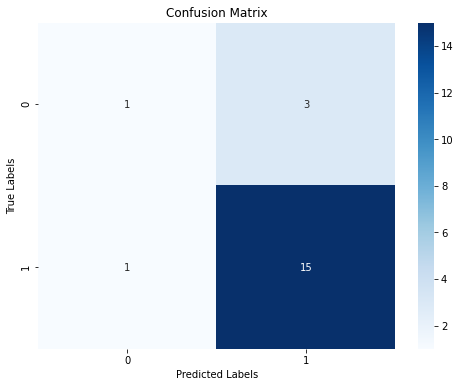

In [47]:
# Пресмятане на confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Създаване на heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [48]:
trainX = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
testX = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
# Отпечатване и проверка на формите
print("Shape of trainX is {}".format(trainX.shape))
print("Shape of testX is {}".format(testX.shape))

Shape of trainX is (80, 8, 1)
Shape of testX is (20, 8, 1)


In [49]:
# Изчисляване на precision, accuracy и sensitivity (recall)
pred_ann = classifier.predict(x_test)
class_rep_ann = classification_report(y_test, pred_ann)
print(class_rep_ann)

1/1 [==============================] - 0s 41ms/step
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       0.83      0.94      0.88        16

    accuracy                           0.80        20
   macro avg       0.67      0.59      0.61        20
weighted avg       0.77      0.80      0.77        20



#### RNN

In [50]:
from keras.layers import Dense, SimpleRNN, Dropout
from keras.metrics import mean_squared_error
from keras.models import Sequential
model = Sequential()
# Добавете първия слой и регуларизацията на Dropout
model.add(SimpleRNN(units=100,activation='tanh',return_sequences=True, 
                    input_shape=(trainX.shape[1],1)))
model.add(Dropout(0.20))
# Втори слой и регуларизация на Dropout
model.add(SimpleRNN(units = 100, activation='tanh',return_sequences=True))
model.add(Dropout(0.20))
# Трети слой и регуларизация Dropout
model.add(SimpleRNN(units = 70, activation='tanh', return_sequences= True))
model.add(Dropout(0.20))
# Четвърти слой и регуларизация Dropout
model.add(SimpleRNN(units = 50))
model.add(Dropout(0.20))
# Добавяне на последен или изходен слой
model.add(Dense(units=1))

# Компилиране на RNN модела
model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics = ['accuracy'])
# Приспособяване на RNN към обучаващата съвкупност
model.fit(trainX, y_train, epochs = 200, batch_size=32)

# Запомнете; епохите, batch_size и т.н. са само някои от хиперпараметрите. 
# Можете да промените тези параметри, както искате
mean = accuracies.mean()
variance = accuracies.std()
print("Accuracy mean: "+ str(mean))
print("Accuracy variance: "+ str(variance))

Epoch 1/200
3/3 [==============================] - 8s 21ms/step - loss: 2.5035 - accuracy: 0.5500
Epoch 2/200
3/3 [==============================] - 0s 21ms/step - loss: 1.0064 - accuracy: 0.5875
Epoch 3/200
3/3 [==============================] - 0s 19ms/step - loss: 1.1689 - accuracy: 0.4500
Epoch 4/200
3/3 [==============================] - 0s 19ms/step - loss: 0.7466 - accuracy: 0.6125
Epoch 5/200
3/3 [==============================] - 0s 21ms/step - loss: 0.8930 - accuracy: 0.5500
Epoch 6/200
3/3 [==============================] - 0s 22ms/step - loss: 0.6871 - accuracy: 0.5875
Epoch 7/200
3/3 [==============================] - 0s 19ms/step - loss: 0.6338 - accuracy: 0.5875
Epoch 8/200
3/3 [==============================] - 0s 20ms/step - loss: 0.4924 - accuracy: 0.6250
Epoch 9/200
3/3 [==============================] - 0s 20ms/step - loss: 0.5842 - accuracy: 0.6125
Epoch 10/200
3/3 [==============================] - 0s 20ms/step - loss: 0.5039 - accuracy: 0.6500
Epoch 11/200
3/3 [=

3/3 [==============================] - 0s 22ms/step - loss: 0.2002 - accuracy: 0.7625
Epoch 84/200
3/3 [==============================] - 0s 22ms/step - loss: 0.2017 - accuracy: 0.7875
Epoch 85/200
3/3 [==============================] - 0s 22ms/step - loss: 0.2651 - accuracy: 0.7250
Epoch 86/200
3/3 [==============================] - 0s 19ms/step - loss: 0.2408 - accuracy: 0.6750
Epoch 87/200
3/3 [==============================] - 0s 25ms/step - loss: 0.2350 - accuracy: 0.7500
Epoch 88/200
3/3 [==============================] - 0s 22ms/step - loss: 0.2157 - accuracy: 0.7125
Epoch 89/200
3/3 [==============================] - 0s 23ms/step - loss: 0.2294 - accuracy: 0.8000
Epoch 90/200
3/3 [==============================] - 0s 22ms/step - loss: 0.2549 - accuracy: 0.7250
Epoch 91/200
3/3 [==============================] - 0s 20ms/step - loss: 0.2646 - accuracy: 0.7125
Epoch 92/200
3/3 [==============================] - 0s 21ms/step - loss: 0.2536 - accuracy: 0.7500
Epoch 93/200
3/3 [=====

3/3 [==============================] - 0s 20ms/step - loss: 0.1489 - accuracy: 0.8250
Epoch 166/200
3/3 [==============================] - 0s 19ms/step - loss: 0.1279 - accuracy: 0.8250
Epoch 167/200
3/3 [==============================] - 0s 20ms/step - loss: 0.1896 - accuracy: 0.7375
Epoch 168/200
3/3 [==============================] - 0s 19ms/step - loss: 0.1368 - accuracy: 0.8500
Epoch 169/200
3/3 [==============================] - 0s 20ms/step - loss: 0.1484 - accuracy: 0.8375
Epoch 170/200
3/3 [==============================] - 0s 19ms/step - loss: 0.1492 - accuracy: 0.7875
Epoch 171/200
3/3 [==============================] - 0s 19ms/step - loss: 0.1147 - accuracy: 0.8875
Epoch 172/200
3/3 [==============================] - 0s 19ms/step - loss: 0.1588 - accuracy: 0.7750
Epoch 173/200
3/3 [==============================] - 0s 19ms/step - loss: 0.1526 - accuracy: 0.8500
Epoch 174/200
3/3 [==============================] - 0s 18ms/step - loss: 0.1545 - accuracy: 0.8750
Epoch 175/200


1/1 [==============================] - 1s 1s/step


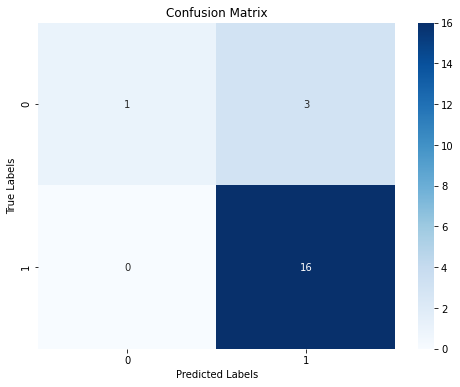

In [51]:
# Получаване на предсказани етикети
y_pred = model.predict(testX)
y_pred = (y_pred > 0.5).astype(int)

# Получаване на истински етикети
y_true = y_test

# Изчисляване на confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Създаване на heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [52]:
method_names.append("RNN")
method_scores.append(0.851)

In [53]:
# Изчисляване на precision, accuracy и sensitivity (recall)
pred_rnn = model.predict(testX).round()
class_rep_rnn = classification_report(y_test, pred_rnn)
print(class_rep_rnn)

1/1 [==============================] - 0s 46ms/step
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.84      1.00      0.91        16

    accuracy                           0.85        20
   macro avg       0.92      0.62      0.66        20
weighted avg       0.87      0.85      0.81        20



#### MLP

In [54]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

# Функция за изграждане на MLP модел
def build_classifier():
    model = Sequential()
    model.add(Dense(units=50, kernel_initializer='uniform', activation='relu', input_dim=x_train.shape[1]))
    model.add(Dense(units=10, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Създаване на KerasClassifier
classifier = KerasClassifier(build_fn=build_classifier, epochs=200, batch_size=32)
classifier.fit(x_train, y_train)

# Извършване на кръстосано валидиране
accuracies = cross_val_score(estimator=classifier, X=x_train, y=y_train, cv=3)
mean_accuracy = accuracies.mean()
variance_accuracy = accuracies.std()

print("Accuracy mean: "+ str(mean_accuracy))
print("Accuracy variance: "+ str(variance_accuracy))

<ipython-input-54-8db40a2340ec>:16: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



Epoch 1/200
3/3 [==============================] - 1s 5ms/step - loss: 0.6932 - accuracy: 0.4000
Epoch 2/200
3/3 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5750
Epoch 3/200
3/3 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5750
Epoch 4/200
3/3 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5750
Epoch 5/200
3/3 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.5750
Epoch 6/200
3/3 [==============================] - 0s 7ms/step - loss: 0.6918 - accuracy: 0.5750
Epoch 7/200
3/3 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.5750
Epoch 8/200
3/3 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.5750
Epoch 9/200
3/3 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5750
Epoch 10/200
3/3 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.5750
Epoch 11/200
3/3 [===========

3/3 [==============================] - 0s 5ms/step - loss: 0.3475 - accuracy: 0.8875
Epoch 85/200
3/3 [==============================] - 0s 5ms/step - loss: 0.3457 - accuracy: 0.8875
Epoch 86/200
3/3 [==============================] - 0s 6ms/step - loss: 0.3435 - accuracy: 0.9000
Epoch 87/200
3/3 [==============================] - 0s 5ms/step - loss: 0.3417 - accuracy: 0.8875
Epoch 88/200
3/3 [==============================] - 0s 5ms/step - loss: 0.3394 - accuracy: 0.8875
Epoch 89/200
3/3 [==============================] - 0s 6ms/step - loss: 0.3378 - accuracy: 0.8875
Epoch 90/200
3/3 [==============================] - 0s 5ms/step - loss: 0.3374 - accuracy: 0.8875
Epoch 91/200
3/3 [==============================] - 0s 7ms/step - loss: 0.3355 - accuracy: 0.8875
Epoch 92/200
3/3 [==============================] - 0s 5ms/step - loss: 0.3333 - accuracy: 0.8875
Epoch 93/200
3/3 [==============================] - 0s 5ms/step - loss: 0.3312 - accuracy: 0.8875
Epoch 94/200
3/3 [===============

3/3 [==============================] - 0s 5ms/step - loss: 0.2769 - accuracy: 0.8875
Epoch 168/200
3/3 [==============================] - 0s 5ms/step - loss: 0.2783 - accuracy: 0.8875
Epoch 169/200
3/3 [==============================] - 0s 5ms/step - loss: 0.2770 - accuracy: 0.8875
Epoch 170/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2772 - accuracy: 0.8875
Epoch 171/200
3/3 [==============================] - 0s 5ms/step - loss: 0.2761 - accuracy: 0.8750
Epoch 172/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2766 - accuracy: 0.8875
Epoch 173/200
3/3 [==============================] - 0s 5ms/step - loss: 0.2751 - accuracy: 0.8875
Epoch 174/200
3/3 [==============================] - 0s 5ms/step - loss: 0.2758 - accuracy: 0.8875
Epoch 175/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2743 - accuracy: 0.8875
Epoch 176/200
3/3 [==============================] - 0s 5ms/step - loss: 0.2739 - accuracy: 0.8875
Epoch 177/200
3/3 [=====

2/2 [==============================] - 0s 7ms/step - loss: 0.5579 - accuracy: 0.8491
Epoch 51/200
2/2 [==============================] - 0s 8ms/step - loss: 0.5508 - accuracy: 0.8679
Epoch 52/200
2/2 [==============================] - 0s 7ms/step - loss: 0.5434 - accuracy: 0.8679
Epoch 53/200
2/2 [==============================] - 0s 7ms/step - loss: 0.5366 - accuracy: 0.8679
Epoch 54/200
2/2 [==============================] - 0s 7ms/step - loss: 0.5295 - accuracy: 0.8679
Epoch 55/200
2/2 [==============================] - 0s 6ms/step - loss: 0.5217 - accuracy: 0.8679
Epoch 56/200
2/2 [==============================] - 0s 6ms/step - loss: 0.5147 - accuracy: 0.8679
Epoch 57/200
2/2 [==============================] - 0s 7ms/step - loss: 0.5089 - accuracy: 0.8679
Epoch 58/200
2/2 [==============================] - 0s 6ms/step - loss: 0.5015 - accuracy: 0.8679
Epoch 59/200
2/2 [==============================] - 0s 8ms/step - loss: 0.4935 - accuracy: 0.8679
Epoch 60/200
2/2 [===============

2/2 [==============================] - 0s 7ms/step - loss: 0.2793 - accuracy: 0.9245
Epoch 134/200
2/2 [==============================] - 0s 7ms/step - loss: 0.2783 - accuracy: 0.9245
Epoch 135/200
2/2 [==============================] - 0s 9ms/step - loss: 0.2764 - accuracy: 0.9245
Epoch 136/200
2/2 [==============================] - 0s 8ms/step - loss: 0.2749 - accuracy: 0.9245
Epoch 137/200
2/2 [==============================] - 0s 8ms/step - loss: 0.2732 - accuracy: 0.9245
Epoch 138/200
2/2 [==============================] - 0s 7ms/step - loss: 0.2719 - accuracy: 0.9245
Epoch 139/200
2/2 [==============================] - 0s 7ms/step - loss: 0.2703 - accuracy: 0.9245
Epoch 140/200
2/2 [==============================] - 0s 8ms/step - loss: 0.2685 - accuracy: 0.9245
Epoch 141/200
2/2 [==============================] - 0s 7ms/step - loss: 0.2669 - accuracy: 0.9245
Epoch 142/200
2/2 [==============================] - 0s 8ms/step - loss: 0.2655 - accuracy: 0.9245
Epoch 143/200
2/2 [=====

2/2 [==============================] - 0s 8ms/step - loss: 0.6899 - accuracy: 0.5472
Epoch 16/200
2/2 [==============================] - 0s 8ms/step - loss: 0.6894 - accuracy: 0.5472
Epoch 17/200
2/2 [==============================] - 0s 8ms/step - loss: 0.6889 - accuracy: 0.5472
Epoch 18/200
2/2 [==============================] - 0s 8ms/step - loss: 0.6884 - accuracy: 0.5472
Epoch 19/200
2/2 [==============================] - 0s 8ms/step - loss: 0.6876 - accuracy: 0.5472
Epoch 20/200
2/2 [==============================] - 0s 9ms/step - loss: 0.6870 - accuracy: 0.5472
Epoch 21/200
2/2 [==============================] - 0s 8ms/step - loss: 0.6862 - accuracy: 0.5472
Epoch 22/200
2/2 [==============================] - 0s 8ms/step - loss: 0.6852 - accuracy: 0.5472
Epoch 23/200
2/2 [==============================] - 0s 8ms/step - loss: 0.6844 - accuracy: 0.5472
Epoch 24/200
2/2 [==============================] - 0s 9ms/step - loss: 0.6832 - accuracy: 0.5472
Epoch 25/200
2/2 [===============

2/2 [==============================] - 0s 7ms/step - loss: 0.3713 - accuracy: 0.8679
Epoch 99/200
2/2 [==============================] - 0s 9ms/step - loss: 0.3686 - accuracy: 0.8679
Epoch 100/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3651 - accuracy: 0.8491
Epoch 101/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3621 - accuracy: 0.8491
Epoch 102/200
2/2 [==============================] - 0s 6ms/step - loss: 0.3595 - accuracy: 0.8491
Epoch 103/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3563 - accuracy: 0.8679
Epoch 104/200
2/2 [==============================] - 0s 7ms/step - loss: 0.3533 - accuracy: 0.8491
Epoch 105/200
2/2 [==============================] - 0s 7ms/step - loss: 0.3508 - accuracy: 0.8679
Epoch 106/200
2/2 [==============================] - 0s 7ms/step - loss: 0.3481 - accuracy: 0.8868
Epoch 107/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3452 - accuracy: 0.8868
Epoch 108/200
2/2 [======

2/2 [==============================] - 0s 8ms/step - loss: 0.2442 - accuracy: 0.9245
Epoch 181/200
2/2 [==============================] - 0s 8ms/step - loss: 0.2435 - accuracy: 0.9245
Epoch 182/200
2/2 [==============================] - 0s 9ms/step - loss: 0.2426 - accuracy: 0.9245
Epoch 183/200
2/2 [==============================] - 0s 8ms/step - loss: 0.2419 - accuracy: 0.9245
Epoch 184/200
2/2 [==============================] - 0s 7ms/step - loss: 0.2409 - accuracy: 0.9245
Epoch 185/200
2/2 [==============================] - 0s 8ms/step - loss: 0.2404 - accuracy: 0.9245
Epoch 186/200
2/2 [==============================] - 0s 9ms/step - loss: 0.2400 - accuracy: 0.9245
Epoch 187/200
2/2 [==============================] - 0s 8ms/step - loss: 0.2390 - accuracy: 0.9245
Epoch 188/200
2/2 [==============================] - 0s 7ms/step - loss: 0.2380 - accuracy: 0.9245
Epoch 189/200
2/2 [==============================] - 0s 8ms/step - loss: 0.2374 - accuracy: 0.9245
Epoch 190/200
2/2 [=====

2/2 [==============================] - 0s 7ms/step - loss: 0.5769 - accuracy: 0.6481
Epoch 56/200
2/2 [==============================] - 0s 8ms/step - loss: 0.5729 - accuracy: 0.6481
Epoch 57/200
2/2 [==============================] - 0s 9ms/step - loss: 0.5687 - accuracy: 0.6481
Epoch 58/200
2/2 [==============================] - 0s 8ms/step - loss: 0.5649 - accuracy: 0.6481
Epoch 59/200
2/2 [==============================] - 0s 8ms/step - loss: 0.5607 - accuracy: 0.6481
Epoch 60/200
2/2 [==============================] - 0s 7ms/step - loss: 0.5564 - accuracy: 0.6481
Epoch 61/200
2/2 [==============================] - 0s 7ms/step - loss: 0.5520 - accuracy: 0.6667
Epoch 62/200
2/2 [==============================] - 0s 8ms/step - loss: 0.5474 - accuracy: 0.6667
Epoch 63/200
2/2 [==============================] - 0s 6ms/step - loss: 0.5427 - accuracy: 0.6852
Epoch 64/200
2/2 [==============================] - 0s 8ms/step - loss: 0.5379 - accuracy: 0.6852
Epoch 65/200
2/2 [===============

2/2 [==============================] - 0s 7ms/step - loss: 0.3308 - accuracy: 0.8889
Epoch 139/200
2/2 [==============================] - 0s 7ms/step - loss: 0.3301 - accuracy: 0.8889
Epoch 140/200
2/2 [==============================] - 0s 7ms/step - loss: 0.3288 - accuracy: 0.8889
Epoch 141/200
2/2 [==============================] - 0s 7ms/step - loss: 0.3292 - accuracy: 0.8704
Epoch 142/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3280 - accuracy: 0.8704
Epoch 143/200
2/2 [==============================] - 0s 7ms/step - loss: 0.3270 - accuracy: 0.8704
Epoch 144/200
2/2 [==============================] - 0s 7ms/step - loss: 0.3262 - accuracy: 0.8704
Epoch 145/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3256 - accuracy: 0.8704
Epoch 146/200
2/2 [==============================] - 0s 7ms/step - loss: 0.3251 - accuracy: 0.8704
Epoch 147/200
2/2 [==============================] - 0s 7ms/step - loss: 0.3236 - accuracy: 0.8704
Epoch 148/200
2/2 [=====

1/1 [==============================] - 0s 23ms/step


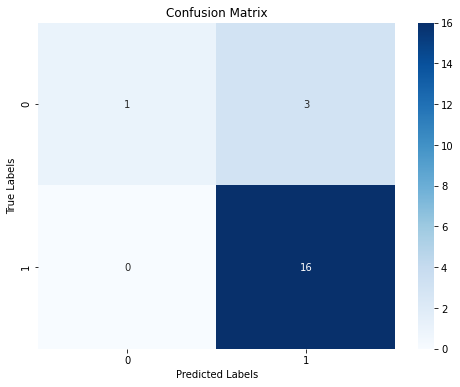

In [55]:
# Получаване на предсказани етикети
y_pred = model.predict(testX)
y_pred = (y_pred > 0.5).astype(int)

# Получаване на истински етикети
y_true = y_test

# Изчисляване на confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Създаване на heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [56]:
method_names.append("MLP")
method_scores.append(0.850)

In [57]:
# Изчисляване на precision, accuracy и sensitivity (recall)
pred_mlp = classifier.predict(x_test)
class_rep_mlp = classification_report(y_test, pred_mlp)
print(class_rep_mlp)

1/1 [==============================] - 0s 63ms/step
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       0.83      0.94      0.88        16

    accuracy                           0.80        20
   macro avg       0.67      0.59      0.61        20
weighted avg       0.77      0.80      0.77        20



### 10. Сравнение на резултатите на алгоритмите

Text(0, 0.5, 'Method Score')

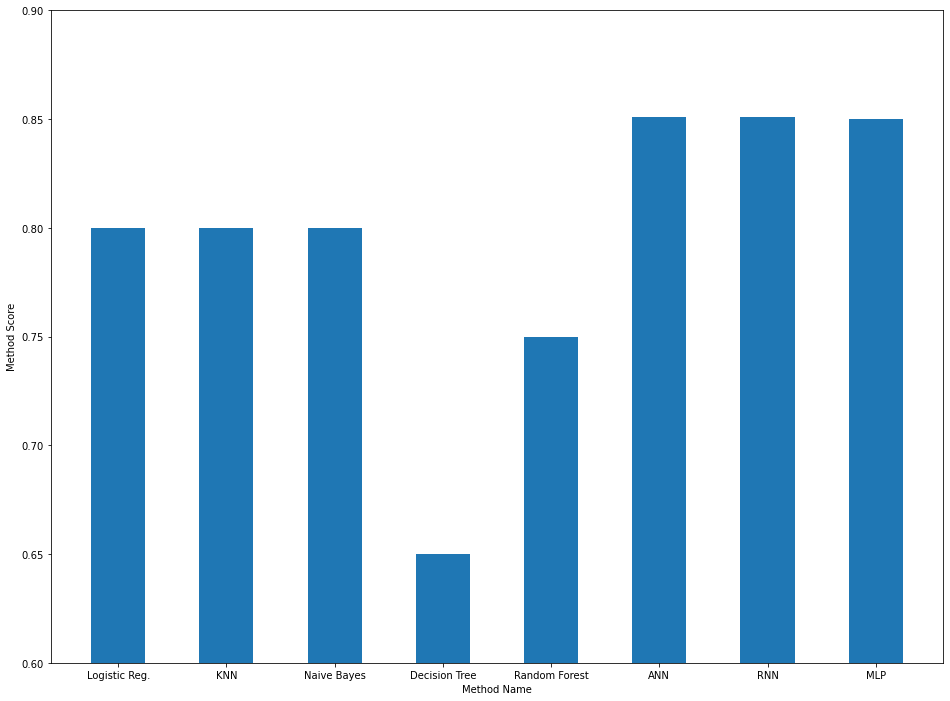

In [58]:
plt.figure(figsize=(16,12))
plt.ylim([0.60,0.90])
plt.bar(method_names,method_scores,width=0.5)
plt.xlabel('Method Name')
plt.ylabel('Method Score')

### Извод

От представените резултати за класификационните алгоритми: ANN, RNN, MLP като невронни мрежи се вижда, че всичките се представят сравнително добре с точност около 85%. При класификационните алгоритми логистичната регресия постига 80% точност, като с подобен резултат са KNN и Naive Bayes. С най-нисък резултат на точност е Decision Tree - 65%. Random Forest постига също добър резултат от 75%.